In [36]:
pip install xgboost catboost optuna

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score
)

from catboost import CatBoostClassifier
import optuna


In [38]:
df = pd.read_csv('online_shoppers_intention.csv')

In [39]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [40]:
df.shape

(12330, 18)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [42]:
df.isna().sum()

,0
Administrative,0
Administrative_Duration,0
Informational,0
Informational_Duration,0
ProductRelated,0
ProductRelated_Duration,0
BounceRates,0
ExitRates,0
PageValues,0
SpecialDay,0


In [43]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [44]:
df.duplicated().sum()

np.int64(125)

In [45]:
df = df.drop_duplicates()

In [46]:
df_processed = df.copy()
df_processed['Month'] = pd.Categorical(df_processed['Month'], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)
df_processed = pd.get_dummies(df_processed, columns=['Month'], prefix='Month')

In [47]:
df_processed = pd.get_dummies(df_processed, columns=['VisitorType'], prefix='VisitorType')

In [48]:
df_processed['Weekend'] = df_processed['Weekend'].astype(int)
df_processed['Revenue'] = df_processed['Revenue'].astype(int)

In [49]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12205 entries, 0 to 12329
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Administrative                 12205 non-null  int64  
 1   Administrative_Duration        12205 non-null  float64
 2   Informational                  12205 non-null  int64  
 3   Informational_Duration         12205 non-null  float64
 4   ProductRelated                 12205 non-null  int64  
 5   ProductRelated_Duration        12205 non-null  float64
 6   BounceRates                    12205 non-null  float64
 7   ExitRates                      12205 non-null  float64
 8   PageValues                     12205 non-null  float64
 9   SpecialDay                     12205 non-null  float64
 10  OperatingSystems               12205 non-null  int64  
 11  Browser                        12205 non-null  int64  
 12  Region                         12205 non-null  int6

In [50]:
df_processed.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_June,Month_Jul,Month_Aug,Month_Sep,Month_Oct,Month_Nov,Month_Dec,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True


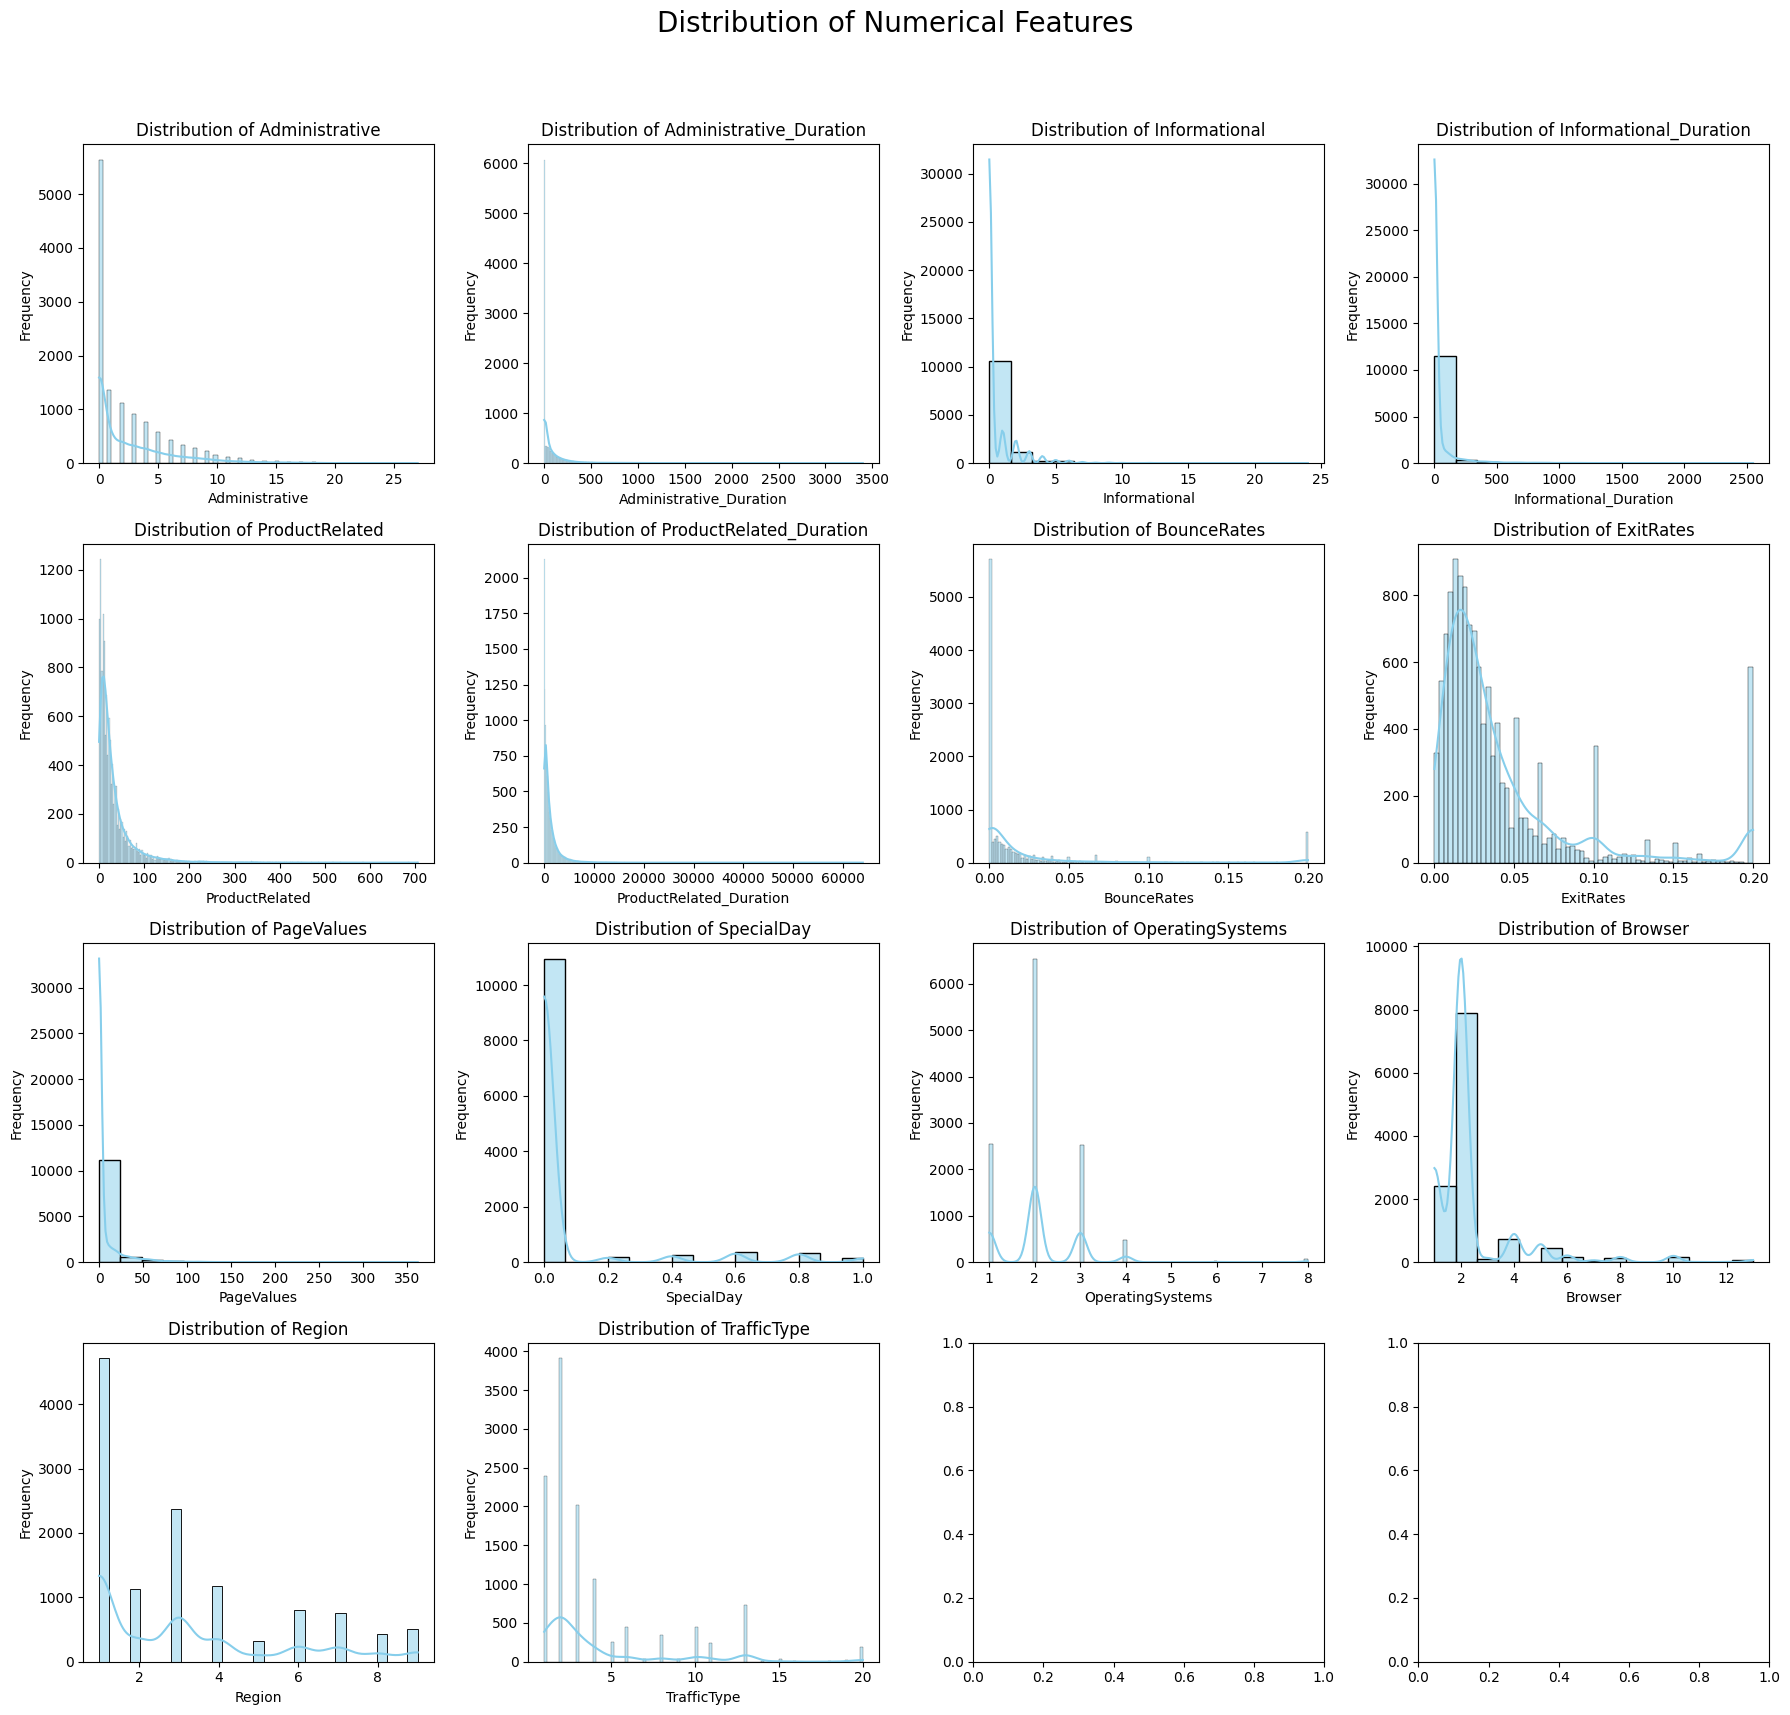

In [51]:
fig, axes = plt.subplots(4, 4, figsize=(18, 18))
fig.suptitle('Distribution of Numerical Features', fontsize=20)
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
for i, feature in enumerate(numerical_features):
    row = i // 4
    col = i % 4
    sns.histplot(df[feature], ax=axes[row, col], kde=True, color='skyblue')
    axes[row, col].set_title(f'Distribution of {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

/tmp/ipython-input-1018803498.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Revenue', data=df, palette='pastel')


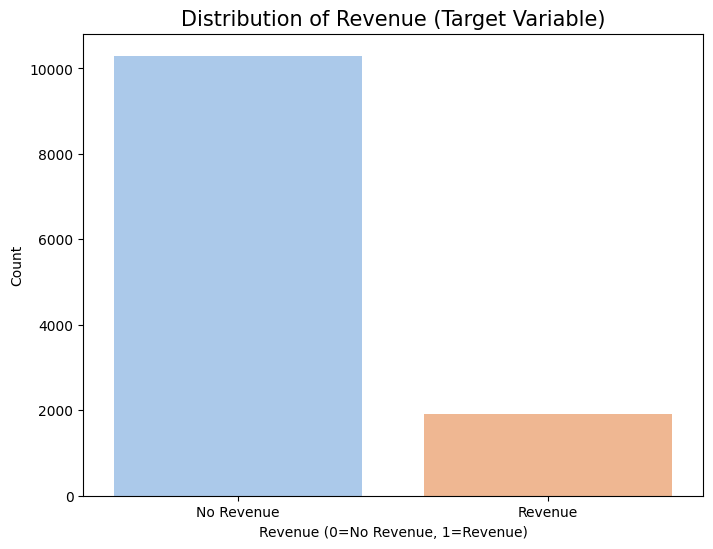

In [52]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Revenue', data=df, palette='pastel')
plt.title('Distribution of Revenue (Target Variable)', fontsize=15)
plt.xlabel('Revenue (0=No Revenue, 1=Revenue)')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Revenue', 'Revenue'])
plt.show()

/tmp/ipython-input-1711335950.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='VisitorType', data=df, palette='viridis')


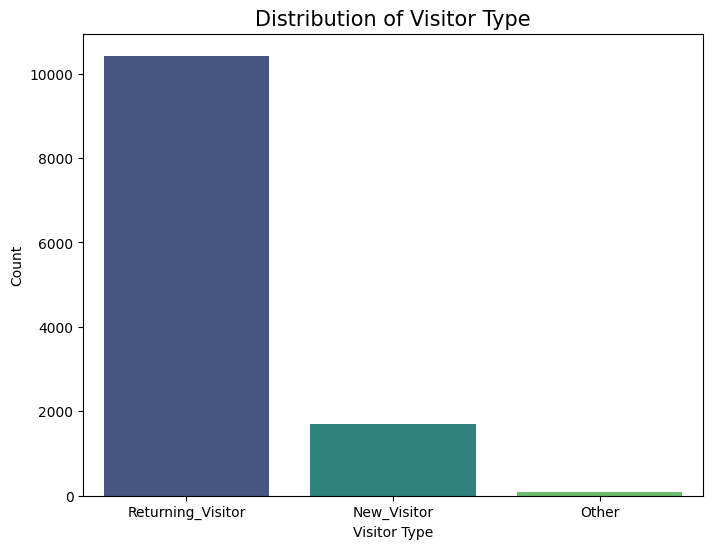

In [53]:
plt.figure(figsize=(8, 6))
sns.countplot(x='VisitorType', data=df, palette='viridis')
plt.title('Distribution of Visitor Type', fontsize=15)
plt.xlabel('Visitor Type')
plt.ylabel('Count')
plt.show()

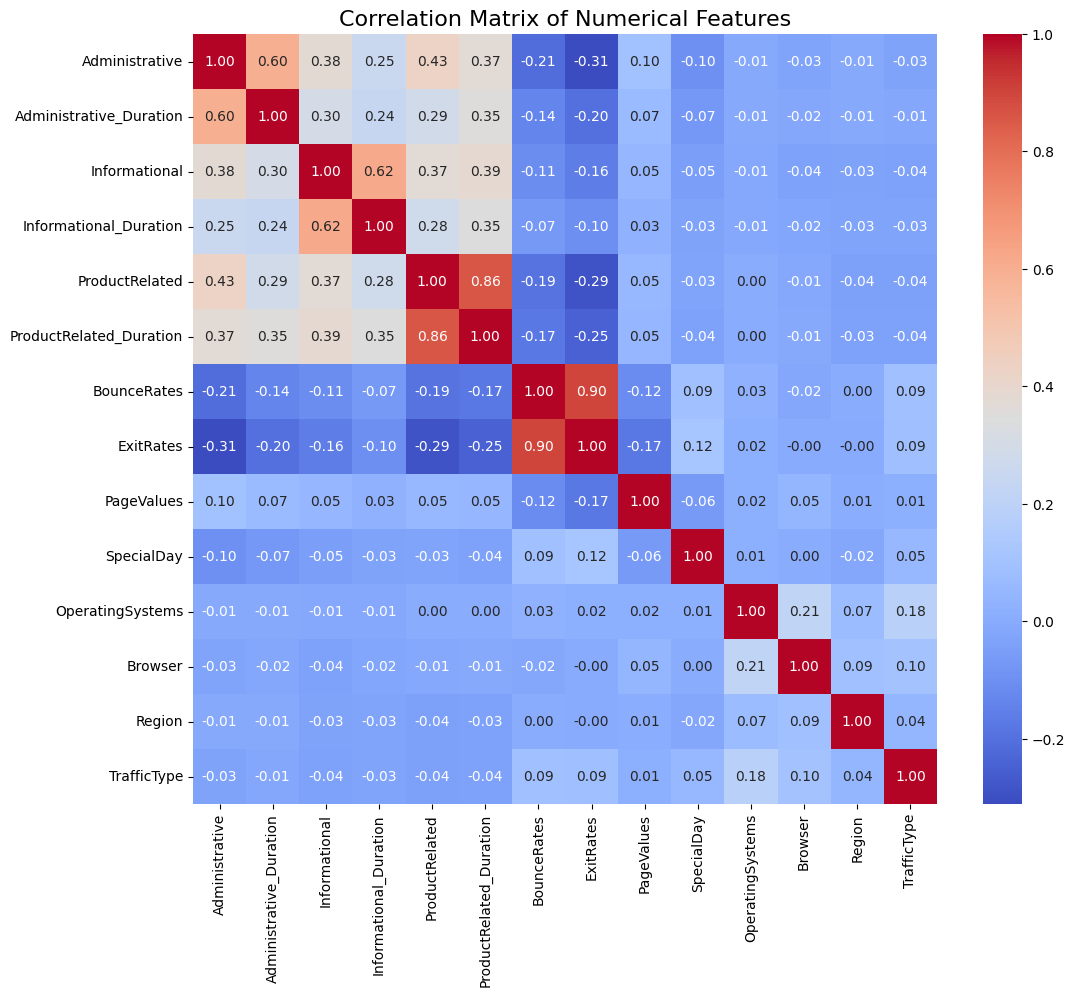

In [54]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

/tmp/ipython-input-3785267169.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Revenue', y='PageValues', data=df, palette='Set2')


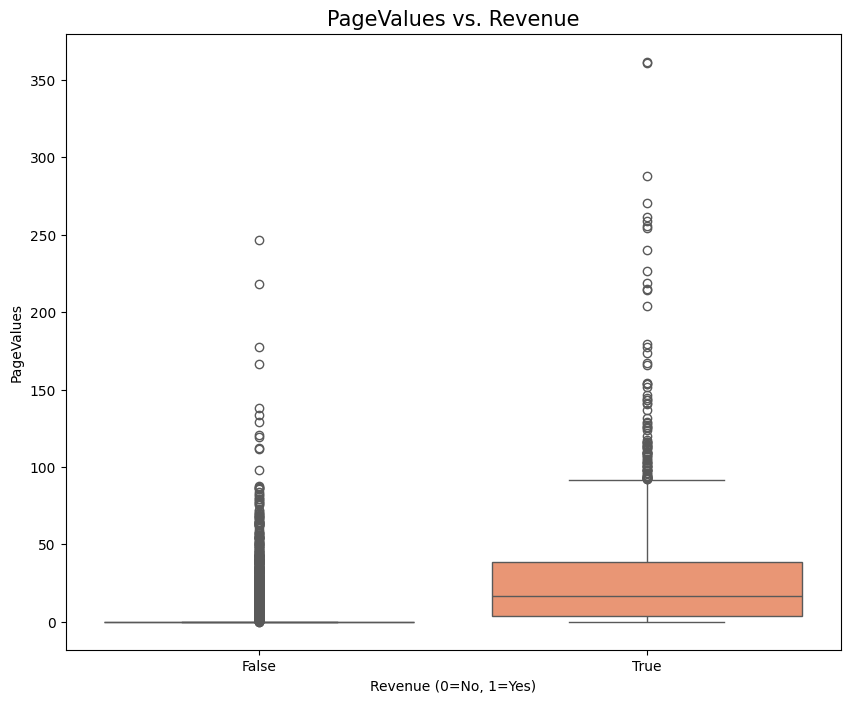

In [55]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='Revenue', y='PageValues', data=df, palette='Set2')
plt.title('PageValues vs. Revenue', fontsize=15)
plt.xlabel('Revenue (0=No, 1=Yes)')
plt.ylabel('PageValues')
plt.show()


/tmp/ipython-input-2801662776.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Revenue', y='ExitRates', data=df, palette='Set2')


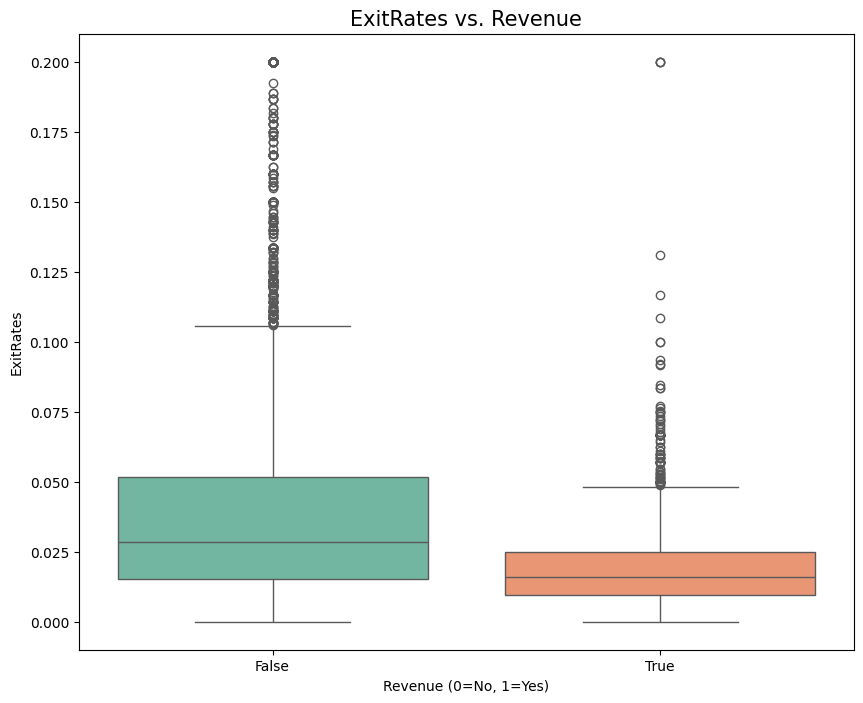

In [56]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='Revenue', y='ExitRates', data=df, palette='Set2')
plt.title('ExitRates vs. Revenue', fontsize=15)
plt.xlabel('Revenue (0=No, 1=Yes)')
plt.ylabel('ExitRates')
plt.show()

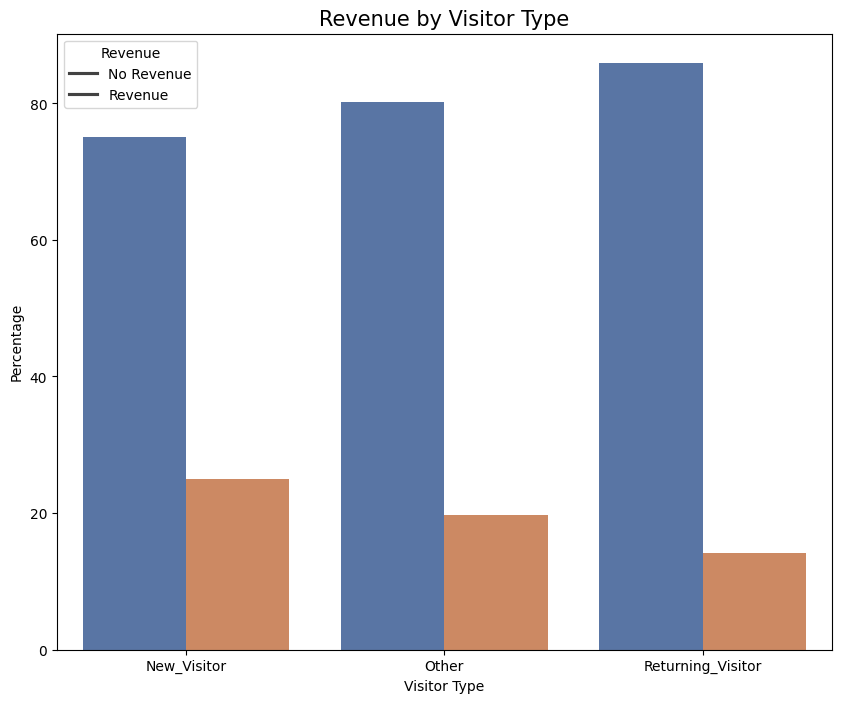

In [57]:
visitor_revenue = pd.crosstab(df['VisitorType'], df['Revenue'], normalize='index') * 100
visitor_revenue = visitor_revenue.reset_index()
visitor_revenue = visitor_revenue.melt(id_vars='VisitorType', var_name='Revenue', value_name='Percentage')

plt.figure(figsize=(10, 8))
sns.barplot(x='VisitorType', y='Percentage', hue='Revenue', data=visitor_revenue, palette='deep')
plt.title('Revenue by Visitor Type', fontsize=15)
plt.xlabel('Visitor Type')
plt.ylabel('Percentage')
plt.legend(title='Revenue', labels=['No Revenue', 'Revenue'])
plt.show()

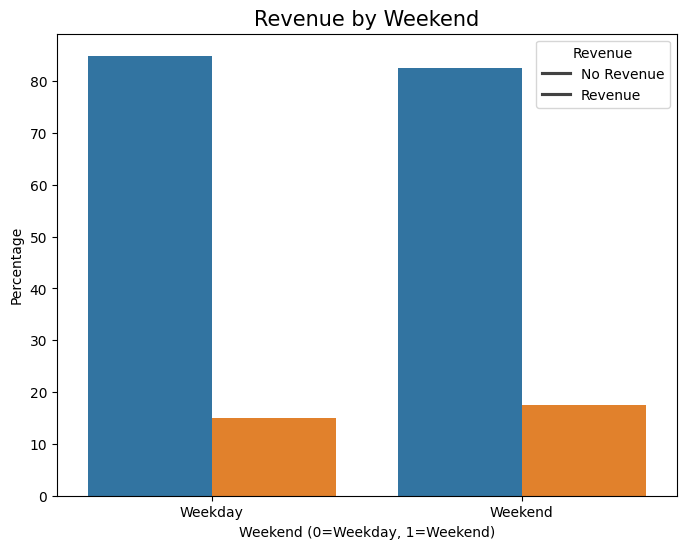

In [58]:
weekend_revenue = pd.crosstab(df['Weekend'], df['Revenue'], normalize='index') * 100
weekend_revenue = weekend_revenue.reset_index()
weekend_revenue = weekend_revenue.melt(id_vars='Weekend', var_name='Revenue', value_name='Percentage')

plt.figure(figsize=(8, 6))
sns.barplot(x='Weekend', y='Percentage', hue='Revenue', data=weekend_revenue, palette='tab10')
plt.title('Revenue by Weekend', fontsize=15)
plt.xlabel('Weekend (0=Weekday, 1=Weekend)')
plt.ylabel('Percentage')
plt.legend(title='Revenue', labels=['No Revenue', 'Revenue'])
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()


# --- Step 5: Feature Engineering ---

In [59]:
df_processed['total_duration'] = df_processed['Administrative_Duration'] + df_processed['Informational_Duration'] + df_processed['ProductRelated_Duration']

In [60]:
df_processed['total_pages_visited'] = df_processed['Administrative'] + df_processed['Informational'] + df_processed['ProductRelated']


In [61]:
print(df_processed[['total_duration', 'total_pages_visited', 'Revenue']].head())

   total_duration  total_pages_visited  Revenue
0        0.000000                    1        0
1       64.000000                    2        0
2        0.000000                    1        0
3        2.666667                    2        0
4      627.500000                   10        0


# --- Step 6: Handling Imbalanced Data with SMOTE ---

In [62]:
X = df_processed.drop('Revenue', axis=1)
y = df_processed['Revenue']

In [63]:
X = pd.get_dummies(X)

In [64]:
print("Original class distribution:", Counter(y))

Original class distribution: Counter({0: 10297, 1: 1908})


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Original training class distribution: {Counter(y_train)}")


Training set shape: (8543, 32), Test set shape: (3662, 32)
Original training class distribution: Counter({0: 7207, 1: 1336})


In [66]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [67]:
print(f"\nResampled training set shape: {X_train_res.shape}")
print(f"Resampled training class distribution: {Counter(y_train_res)}")


Resampled training set shape: (14414, 32)
Resampled training class distribution: Counter({0: 7207, 1: 7207})


/tmp/ipython-input-1418319792.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_res, palette='pastel')


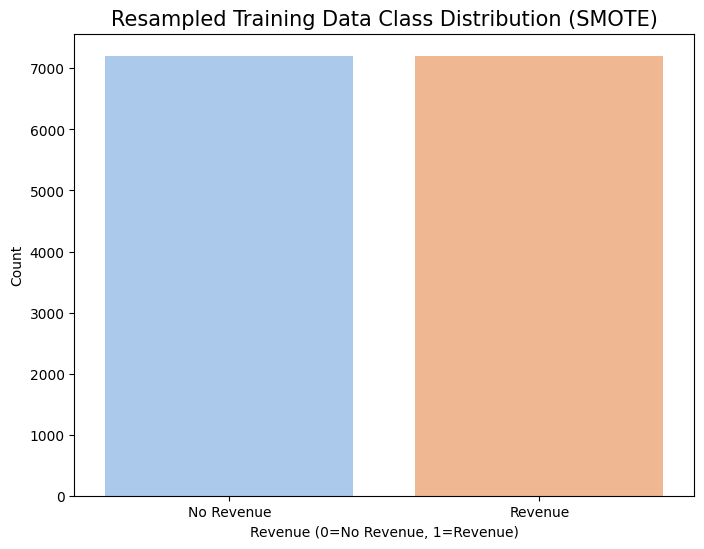

In [68]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_res, palette='pastel')
plt.title('Resampled Training Data Class Distribution (SMOTE)', fontsize=15)
plt.xlabel('Revenue (0=No Revenue, 1=Revenue)')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Revenue', 'Revenue'])
plt.show()

In [79]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """Evaluate model on train & test data with classification report, confusion matrix, and curves."""
    y_pred_test = model.predict(X_test)

    # Probabilities (needed for ROC/PR curves)
    if hasattr(model, "predict_proba"):
        y_prob_test = model.predict_proba(X_test)[:, 1]
    else:
        # Some models don't support predict_proba
        y_prob_test = model.decision_function(X_test)

    test_acc = accuracy_score(y_test, y_pred_test)

    print(f"\n📌 {name} Evaluation")
    print("="*50)
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy : {test_acc:.4f}")
    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_pred_test))

    # ---- Confusion Matrix ----
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ---- ROC Curve ----
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.title(f"{name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # ---- Precision-Recall Curve ----
    precision, recall, _ = precision_recall_curve(y_test, y_prob_test)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f"{name}")
    plt.title(f"{name} - Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    return train_acc, test_acc


In [80]:

def cross_validate_model(name, model, X, y, cv=5):
    """Cross-validation with F1-score."""
    scores = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1)
    print(f"\n📌 {name} Cross-Validation (F1-score): Mean={scores.mean():.4f}, Std={scores.std():.4f}")
    return scores.mean()

In [81]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation



🚀 Training RandomForest ...

📌 RandomForest Evaluation
Train Accuracy: 0.9551
Test Accuracy : 0.8812

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      3090
           1       0.59      0.78      0.67       572

    accuracy                           0.88      3662
   macro avg       0.77      0.84      0.80      3662
weighted avg       0.90      0.88      0.89      3662



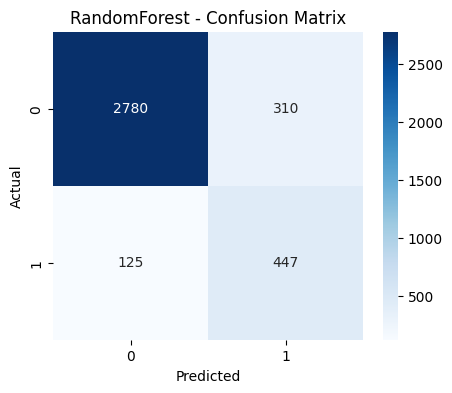

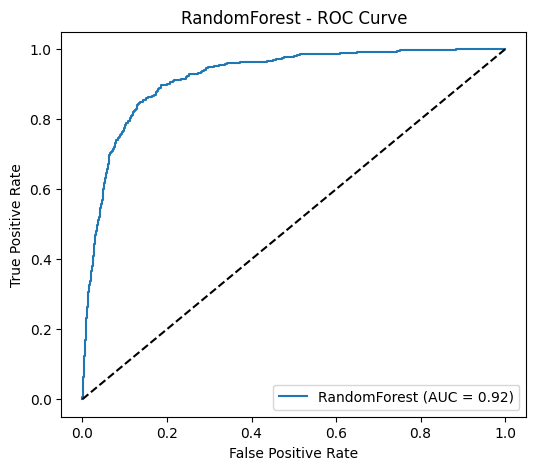

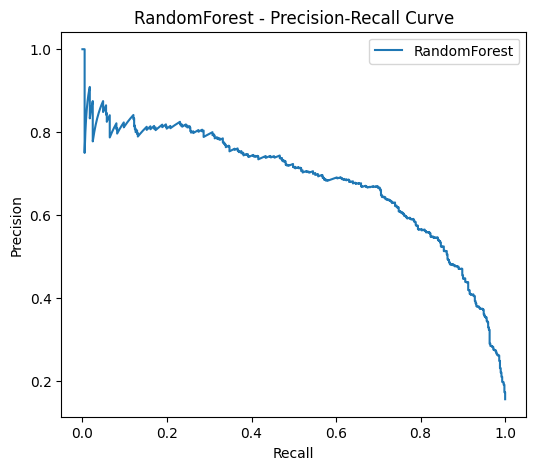


🚀 Training LightGBM ...
[LightGBM] [Info] Number of positive: 7207, number of negative: 7207
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2670
[LightGBM] [Info] Number of data points in the train set: 14414, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.29224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

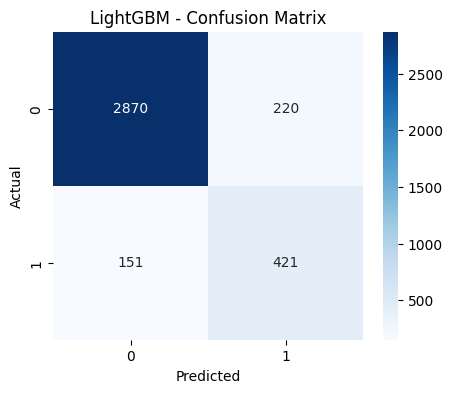

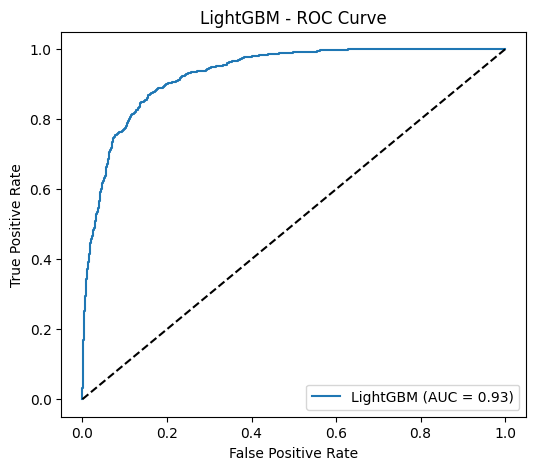

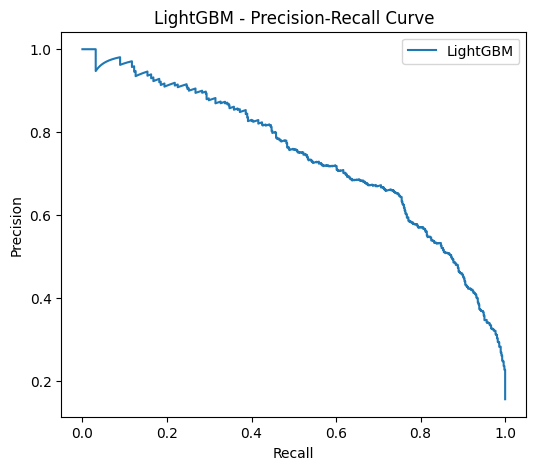


🚀 Training CatBoost ...
0:	learn: 0.6402065	test: 0.6426247	best: 0.6426247 (0)	total: 8.13ms	remaining: 4.06s
100:	learn: 0.1816149	test: 0.2616365	best: 0.2616365 (100)	total: 674ms	remaining: 2.66s
200:	learn: 0.1514284	test: 0.2496375	best: 0.2496375 (200)	total: 1.32s	remaining: 1.96s
300:	learn: 0.1315330	test: 0.2463780	best: 0.2462869 (287)	total: 2s	remaining: 1.32s
400:	learn: 0.1173225	test: 0.2458515	best: 0.2456796 (359)	total: 2.66s	remaining: 657ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2456796205
bestIteration = 359

Shrink model to first 360 iterations.

📌 CatBoost Evaluation
Train Accuracy: 0.9551
Test Accuracy : 0.8962

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3090
           1       0.65      0.72      0.68       572

    accuracy                           0.90      3662
   macro avg       0.80      0.82      0.81      3662
weighted avg       0.

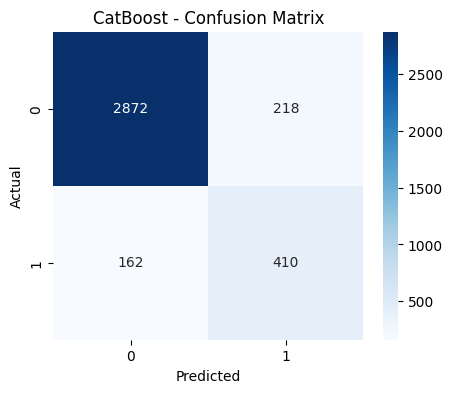

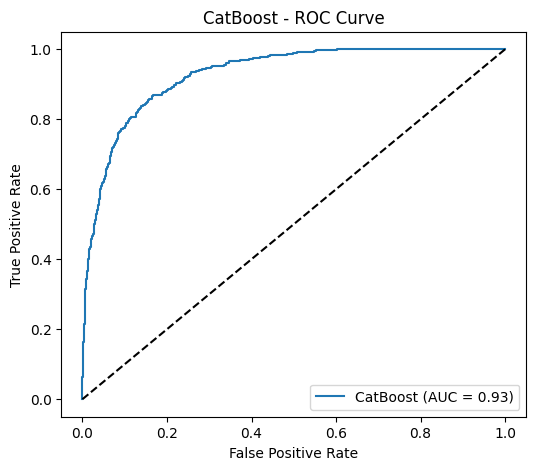

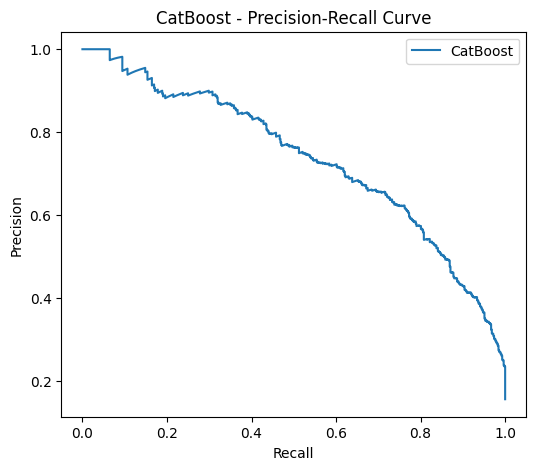

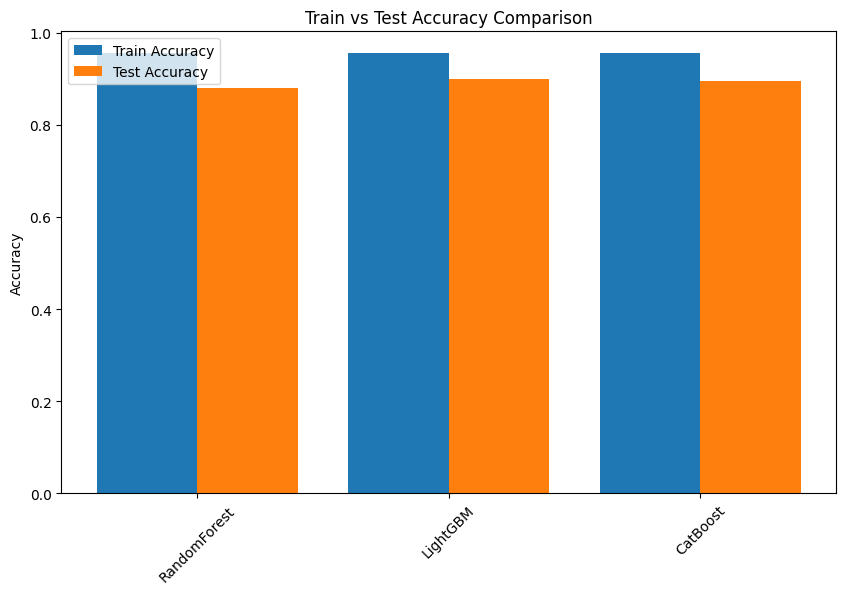

In [82]:


# ==============================================
# 📌 Extended Model Zoo with Early Stopping
# ==============================================
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=150,
        max_depth=8,
        min_samples_split=6,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=200,
        max_depth=5,
        num_leaves=25,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        iterations=500,
        depth=6,
        learning_rate=0.05,
        l2_leaf_reg=5,
        random_state=42,
        verbose=100
    )
}

# ==============================================
# 📌 Train & Evaluate
# ==============================================
results = {}
for name, model in models.items():
    print(f"\n🚀 Training {name} ...")

    if name == "LightGBM":
        # LightGBM early stopping using callbacks
        model.fit(
            X_train_res,
            y_train_res,
            eval_set=[(X_test, y_test)],
            callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
        )
    elif name == "CatBoost":
        # CatBoost early stopping
        model.fit(
            X_train_res,
            y_train_res,
            eval_set=(X_test, y_test),
            early_stopping_rounds=50,
            verbose=100
        )
    else:
        # RandomForest doesn't support early stopping
        model.fit(X_train_res, y_train_res)

    # Evaluate
    train_acc, test_acc = evaluate_model(name, model, X_train_res, y_train_res, X_test, y_test)
    results[name] = (train_acc, test_acc)

# ==============================================
# 📌 Compare Train vs Test Accuracy
# ==============================================
plt.figure(figsize=(10,6))
names = list(results.keys())
train_accs = [results[m][0] for m in names]
test_accs = [results[m][1] for m in names]

x = np.arange(len(names))
plt.bar(x - 0.2, train_accs, 0.4, label="Train Accuracy")
plt.bar(x + 0.2, test_accs, 0.4, label="Test Accuracy")

plt.xticks(x, names, rotation=45)
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy Comparison")
plt.legend()
plt.show()


In [83]:
# ============== 2. Cross-Validation ==============
for name, model in models.items():
    cross_validate_model(name, model, X_train_res, y_train_res)



📌 RandomForest Cross-Validation (F1-score): Mean=0.9140, Std=0.0375

📌 LightGBM Cross-Validation (F1-score): Mean=0.9084, Std=0.0924

📌 CatBoost Cross-Validation (F1-score): Mean=0.9047, Std=0.1098


In [84]:
def tune_randomforest(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 5),
    }
    model = RandomForestClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train_res, y_train_res, cv=3, scoring="f1", n_jobs=-1).mean()
    return score

def tune_lgbm(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
    }
    model = LGBMClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train_res, y_train_res, cv=3, scoring="f1", n_jobs=-1).mean()
    return score

def tune_catboost(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 5)
    }
    model = CatBoostClassifier(**params, random_state=42, verbose=0)
    score = cross_val_score(model, X_train_res, y_train_res, cv=3, scoring="f1", n_jobs=-1).mean()
    return score

[I 2025-09-02 05:13:29,289] A new study created in memory with name: no-name-b9bdaf25-3dec-4991-927d-32f1a87cbe40



🔍 Optuna Tuning - RandomForest


[I 2025-09-02 05:13:33,111] Trial 0 finished with value: 0.918226584071573 and parameters: {'n_estimators': 142, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.918226584071573.
[I 2025-09-02 05:13:36,960] Trial 1 finished with value: 0.9224169038303603 and parameters: {'n_estimators': 103, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9224169038303603.
[I 2025-09-02 05:13:41,702] Trial 2 finished with value: 0.9109534923283945 and parameters: {'n_estimators': 198, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9224169038303603.
[I 2025-09-02 05:13:45,739] Trial 3 finished with value: 0.9269050996541267 and parameters: {'n_estimators': 111, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.9269050996541267.
[I 2025-09-02 05:13:51,708] Trial 4 finished with value: 0.9283571399502577 and parameters: {'n_


📌 RandomForest (Optuna) Evaluation
Train Accuracy: 0.9551
Test Accuracy : 0.8924

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      3090
           1       0.63      0.73      0.68       572

    accuracy                           0.89      3662
   macro avg       0.79      0.83      0.81      3662
weighted avg       0.90      0.89      0.90      3662



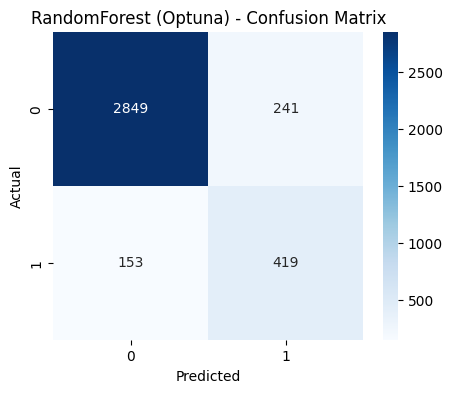

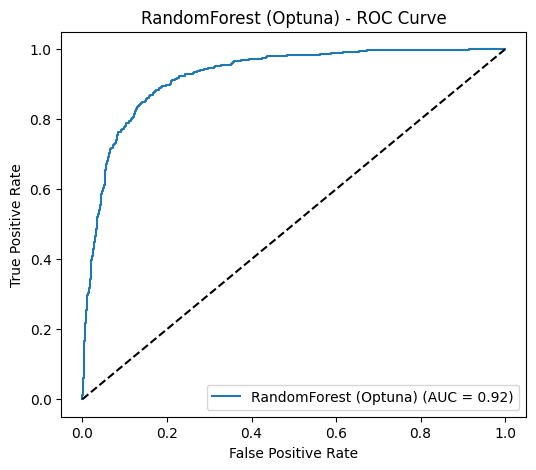

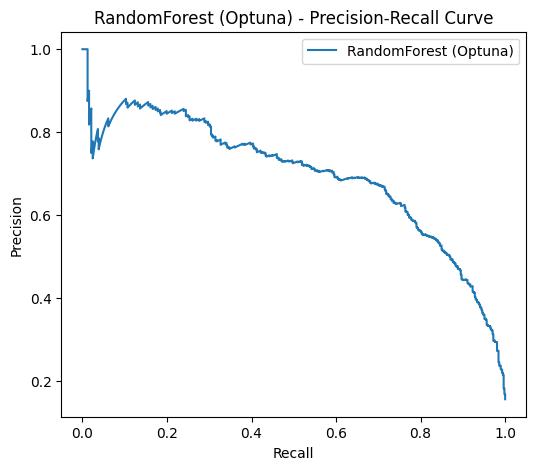

(0.9551130845011794, 0.892408519934462)

In [85]:
# Run tuning (example: RandomForest)
print("\n🔍 Optuna Tuning - RandomForest")
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(tune_randomforest, n_trials=30)

best_rf = RandomForestClassifier(**study_rf.best_params, random_state=42)
best_rf.fit(X_train_res, y_train_res)
evaluate_model("RandomForest (Optuna)", best_rf, X_train_res, y_train_res, X_test, y_test)


[I 2025-09-02 05:15:59,829] A new study created in memory with name: no-name-eb345999-fa95-4f56-99aa-6b8a5e1b1f25



🔍 Optuna Tuning - LightGBM


[I 2025-09-02 05:16:01,003] Trial 0 finished with value: 0.9129433884286916 and parameters: {'n_estimators': 333, 'max_depth': 3, 'learning_rate': 0.01656810763464851, 'num_leaves': 34, 'subsample': 0.7448981840948159, 'colsample_bytree': 0.784859009734528}. Best is trial 0 with value: 0.9129433884286916.
[I 2025-09-02 05:16:02,214] Trial 1 finished with value: 0.919109175941269 and parameters: {'n_estimators': 182, 'max_depth': 7, 'learning_rate': 0.015278295422439617, 'num_leaves': 34, 'subsample': 0.9824417723383332, 'colsample_bytree': 0.9537632785601551}. Best is trial 1 with value: 0.919109175941269.
[I 2025-09-02 05:16:04,123] Trial 2 finished with value: 0.916202295788831 and parameters: {'n_estimators': 294, 'max_depth': 10, 'learning_rate': 0.048802078832417814, 'num_leaves': 36, 'subsample': 0.7085703445768144, 'colsample_bytree': 0.8082582762660789}. Best is trial 1 with value: 0.919109175941269.
[I 2025-09-02 05:16:05,471] Trial 3 finished with value: 0.9110840470958235 an

[LightGBM] [Info] Number of positive: 7207, number of negative: 7207
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2670
[LightGBM] [Info] Number of data points in the train set: 14414, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

📌 LightGBM (Optuna) Evaluation
Train Accuracy: 0.9551
Test Accuracy : 0.8960

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3090
           1       0.65      0.73      0.69       572

    accuracy                           0.90      3662
   macro avg       0.80      0.83      0.81      3662
weighted avg       0.90      0.90      0.90      3662



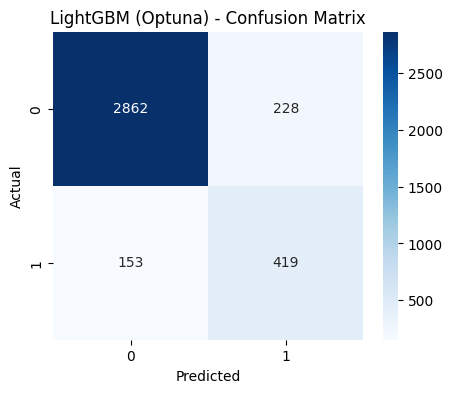

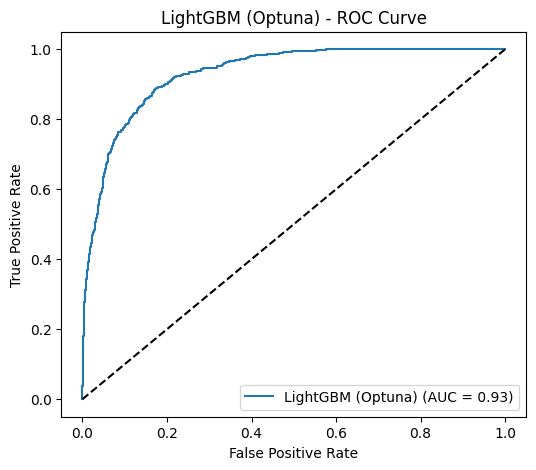

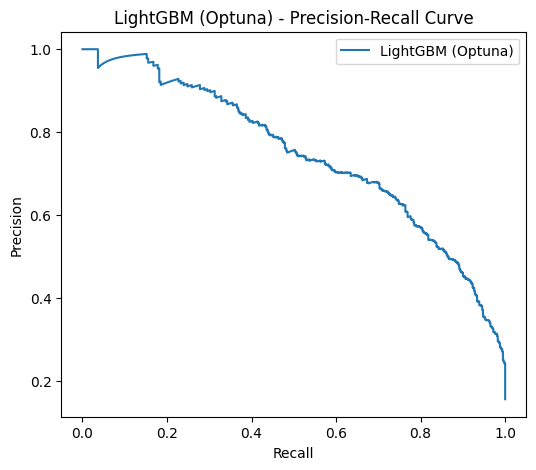

(0.9551130845011794, 0.8959584926269798)

In [86]:
print("\n🔍 Optuna Tuning - LightGBM")
study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(tune_lgbm, n_trials=30)

# Train the best LightGBM model with optimized hyperparameters
best_lgbm = LGBMClassifier(**study_lgbm.best_params, random_state=42)
best_lgbm.fit(X_train_res, y_train_res)

# Evaluate
evaluate_model("LightGBM (Optuna)", best_lgbm, X_train_res, y_train_res, X_test, y_test)


[I 2025-09-02 05:16:49,413] A new study created in memory with name: no-name-03e939c6-5038-4d14-9c74-c32a5a2ec09e



🔍 Optuna Tuning - CatBoost


[I 2025-09-02 05:16:55,000] Trial 0 finished with value: 0.9176691982977405 and parameters: {'iterations': 222, 'depth': 7, 'learning_rate': 0.013454479092844604, 'l2_leaf_reg': 2.468328989003091}. Best is trial 0 with value: 0.9176691982977405.
[I 2025-09-02 05:17:09,384] Trial 1 finished with value: 0.9191037804434828 and parameters: {'iterations': 359, 'depth': 8, 'learning_rate': 0.029013729701776424, 'l2_leaf_reg': 3.3167466881064027}. Best is trial 1 with value: 0.9191037804434828.
[I 2025-09-02 05:17:16,414] Trial 2 finished with value: 0.9128432512892432 and parameters: {'iterations': 428, 'depth': 5, 'learning_rate': 0.03790185250001061, 'l2_leaf_reg': 1.590543245036347}. Best is trial 1 with value: 0.9191037804434828.
[I 2025-09-02 05:17:23,350] Trial 3 finished with value: 0.9148549414784792 and parameters: {'iterations': 284, 'depth': 7, 'learning_rate': 0.07374472698314158, 'l2_leaf_reg': 4.57505382315763}. Best is trial 1 with value: 0.9191037804434828.
[I 2025-09-02 05:1


📌 CatBoost (Optuna) Evaluation
Train Accuracy: 0.9551
Test Accuracy : 0.8932

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      3090
           1       0.63      0.75      0.69       572

    accuracy                           0.89      3662
   macro avg       0.79      0.83      0.81      3662
weighted avg       0.90      0.89      0.90      3662



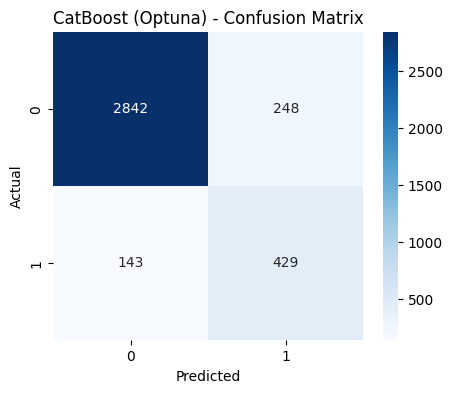

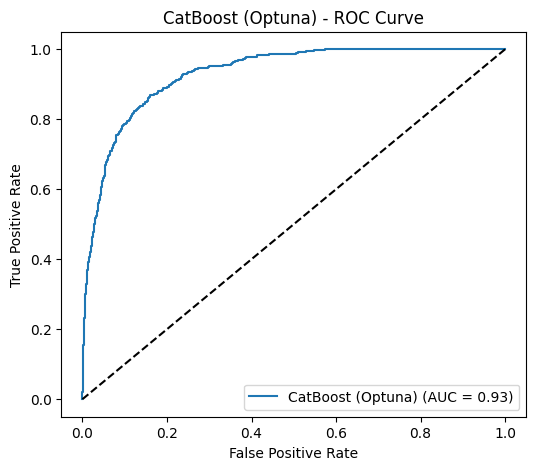

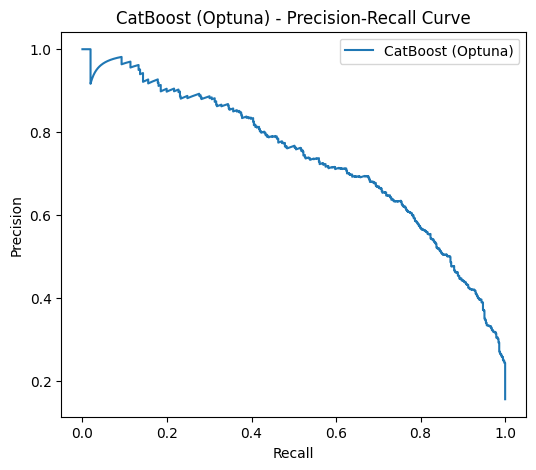

(0.9551130845011794, 0.8932277444019662)

In [87]:
print("\n🔍 Optuna Tuning - CatBoost")
study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(tune_catboost, n_trials=30)

best_cat = CatBoostClassifier(**study_cat.best_params, random_state=42, verbose=0)
best_cat.fit(X_train_res, y_train_res)
evaluate_model("CatBoost (Optuna)", best_cat, X_train_res, y_train_res, X_test, y_test)




📌 Stacking Ensemble (RF + LGBM + CatBoost) Evaluation
Train Accuracy: 0.9551
Test Accuracy : 0.8946

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3090
           1       0.65      0.72      0.68       572

    accuracy                           0.89      3662
   macro avg       0.80      0.82      0.81      3662
weighted avg       0.90      0.89      0.90      3662



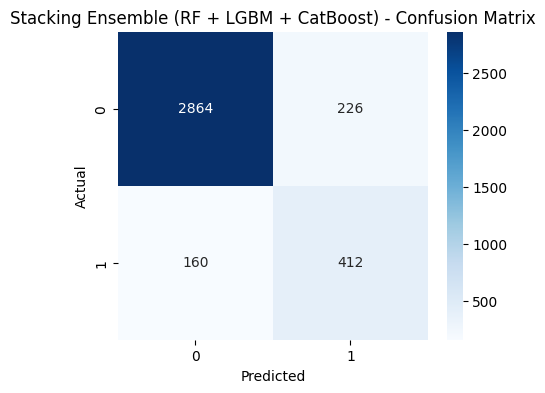

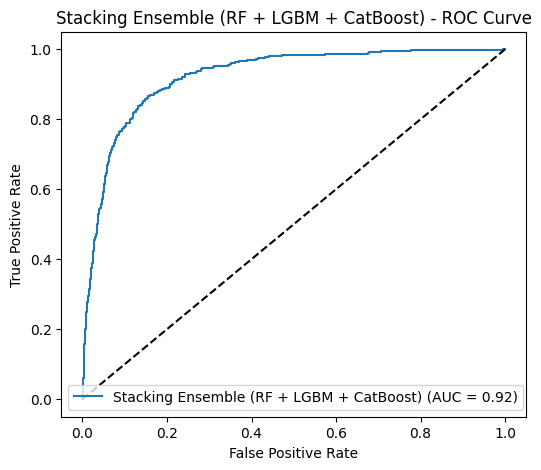

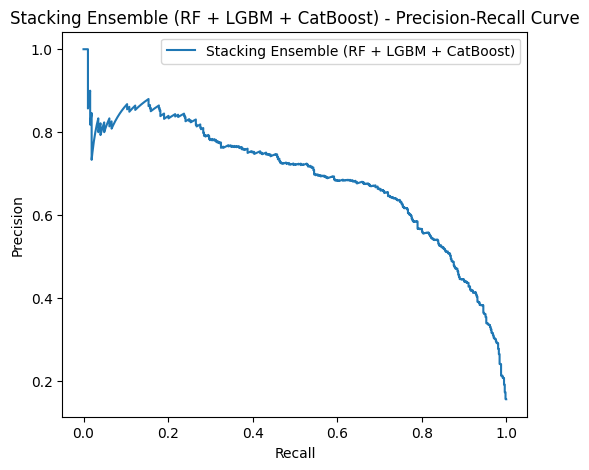

(0.9551130845011794, 0.894593118514473)

In [88]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# ==============================================
# 📌 Stacking Ensemble (RF + LightGBM + CatBoost)
# ==============================================
stack_model = StackingClassifier(
    estimators=[
        ("rf", best_rf),       # Tuned RandomForest
        ("lgbm", best_lgbm),   # Tuned LightGBM
        ("cat", best_cat)      # Tuned CatBoost
    ],
    final_estimator=LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'   # handle class imbalance
    ),
    cv=StratifiedKFold(n_splits=5),  # out-of-fold predictions
    n_jobs=-1
)

# ==============================================
# 📌 Train stacking ensemble
# ==============================================
stack_model.fit(X_train_res, y_train_res)

# ==============================================
# 📌 Evaluate stacking ensemble
# ==============================================
evaluate_model(
    "Stacking Ensemble (RF + LGBM + CatBoost)",
    stack_model,
    X_train_res,
    y_train_res,
    X_test,
    y_test
)
